In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats # for mode calculation

In [24]:
def make_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.build()

    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

    return model

In [25]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [26]:
model = make_model()
model.load_weights("final/final.weights.h5")
loss, accuracy = model.evaluate(x_test, y_test_one_hot, verbose=1)
print(loss, accuracy)

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8354 - loss: 0.4966
0.49297255277633667 0.8348000049591064


In [27]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    input_image_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    input_image_tensor = tf.expand_dims(input_image_tensor, axis=0) # batch size of 1
    input_label = np.expand_dims(input_label, axis=0) # batch size of 1

    with tf.GradientTape() as tape:
        tape.watch(input_image_tensor)
        prediction = model(input_image_tensor)
        loss = loss_object(input_label, prediction)
    
    gradient = tape.gradient(loss, input_image_tensor) # gradient of loss wrt input image
    signed_grad = tf.sign(gradient) # sign of the gradients
    return signed_grad

What do perturbations look like?

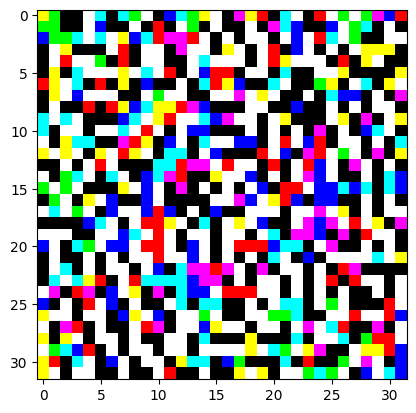

In [28]:
image = x_train[0]
label = y_train_one_hot[0]

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5) # note: black pixels because we are shifting to from [-1, -1] to [0, 1] (so white = (-1, -1, -1))

Apply perturbations to some test images

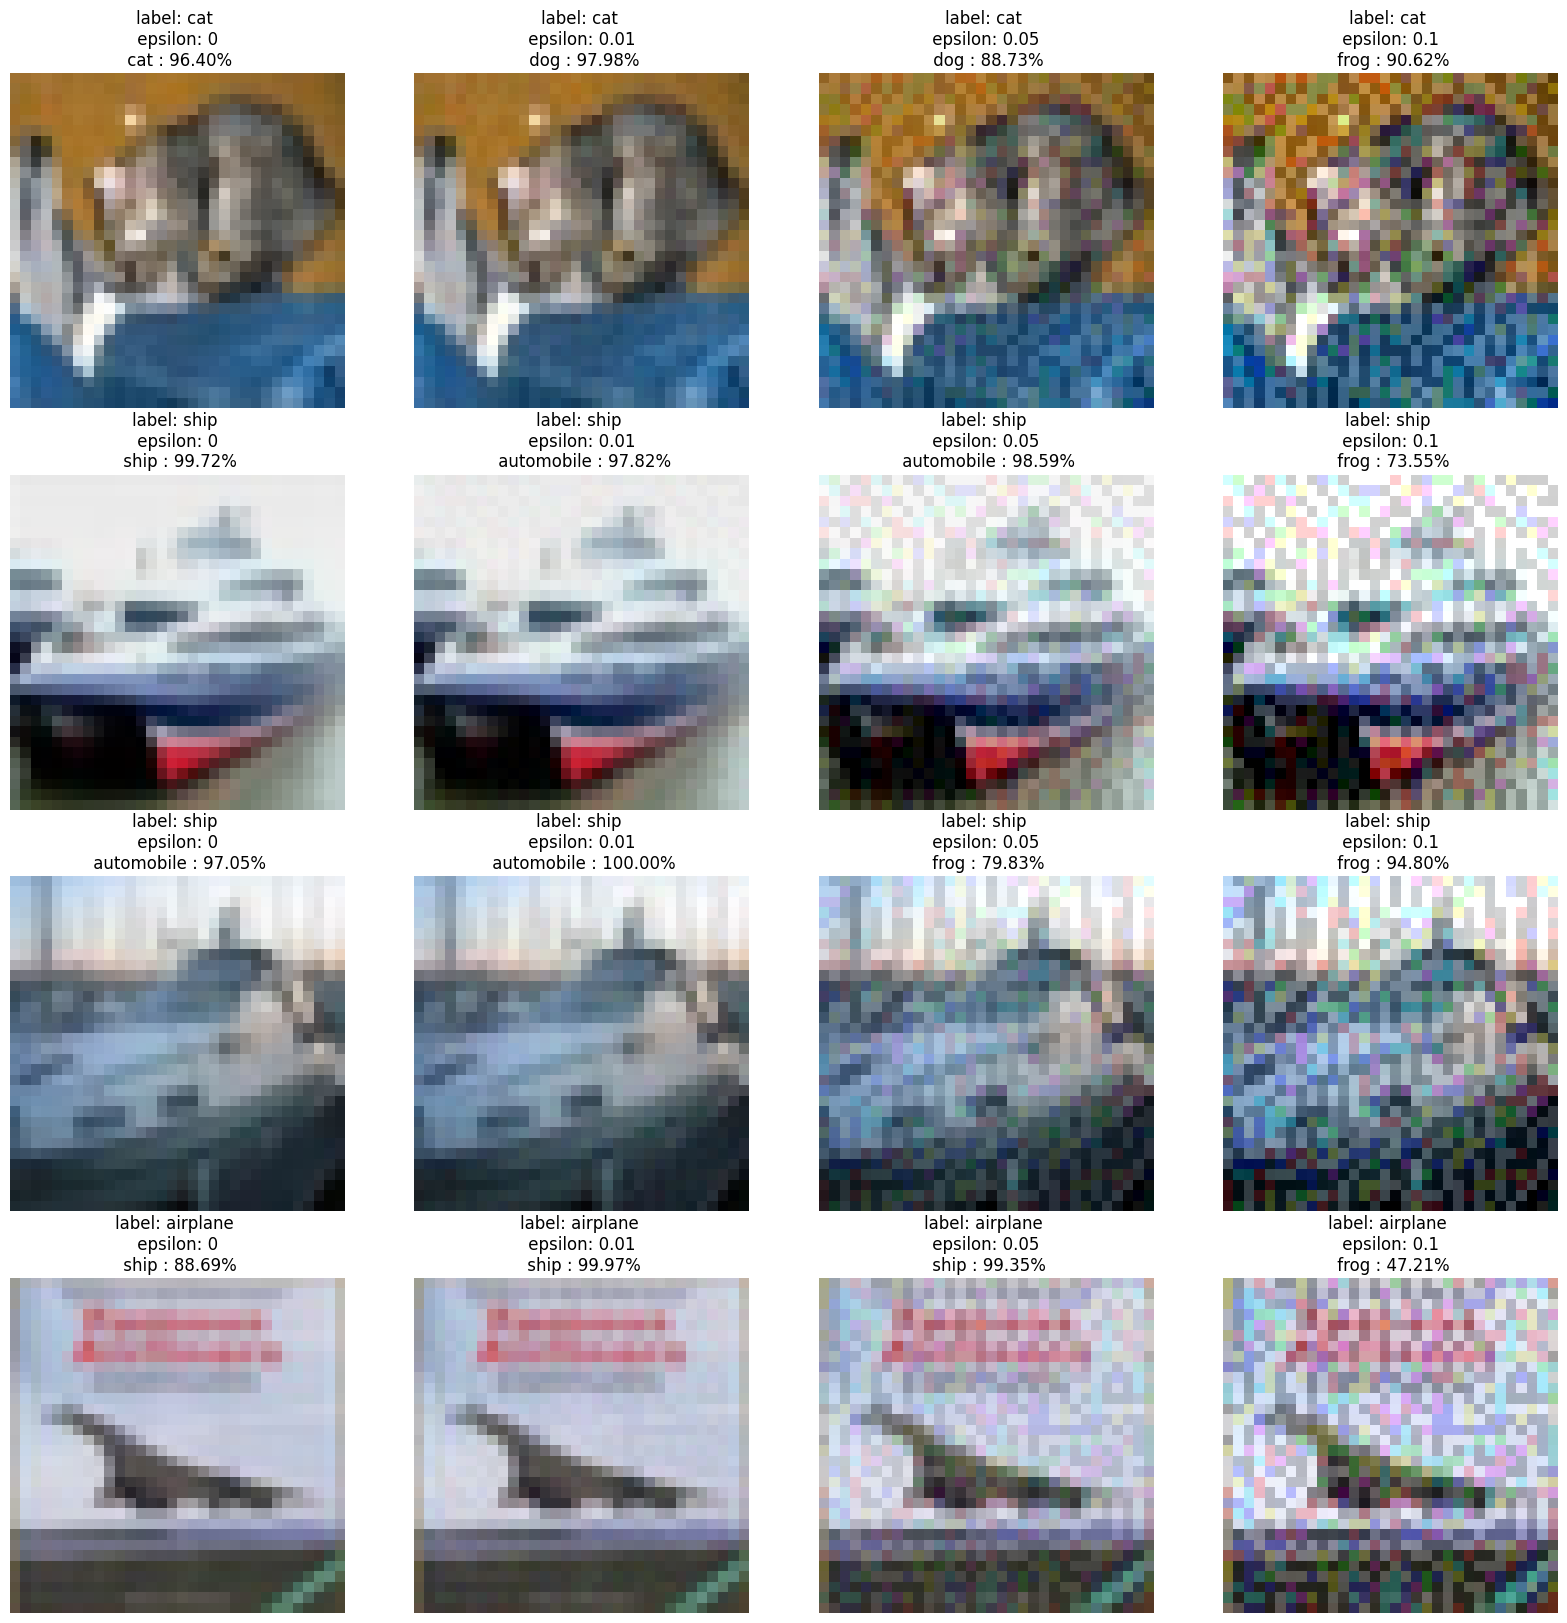

In [44]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
epsilons = [0, 0.01, 0.05, 0.1]

fig = plt.figure(figsize=(20,20))
for j in range(4):
    for i in range(len(epsilons)):
        fig.add_subplot(4, 4, i+1 +j*4)

        x_adv = x_test[j] + epsilons[i] * create_adversarial_pattern(x_test[j], y_test_one_hot[j])
        x_adv = tf.clip_by_value(x_adv, 0, 1)

        prediction = model(x_adv)
        image_class = class_names[np.argmax(prediction)]
        conf = np.max(prediction)
        
        plt.imshow(x_adv[0])
        plt.axis('off')
        plt.title('label: {} \n epsilon: {} \n {} : {:.2f}%'.format(class_names[y_test[j][0]], epsilons[i], image_class, conf * 100))

How much does fgsm hurt model's performance?

In [45]:
eps = 0.01
n = 100
x_adv_test = np.empty(x_test.shape)
for i in range(0, n):
    x_adv_test[i] = x_test[i] + eps * create_adversarial_pattern(x_test[i], y_test_one_hot[i])
    x_adv_test[i] = tf.clip_by_value(x_adv_test[i], 0, 1)

loss, accuracy = model.evaluate(x_adv_test[:n], y_test_one_hot[:n], verbose=1)
print(loss, accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2467 - loss: 4.4662
4.478896617889404 0.25999999046325684


Is it fgsm, or just noise that hurts the performance?

In [ ]:
def create_random_adversarial_pattern(shape):
    pattern = np.random.randint(0, 2, size=shape)
    pattern = pattern * 2 - 1 # change [0,1] to [-1, 1]
    return pattern

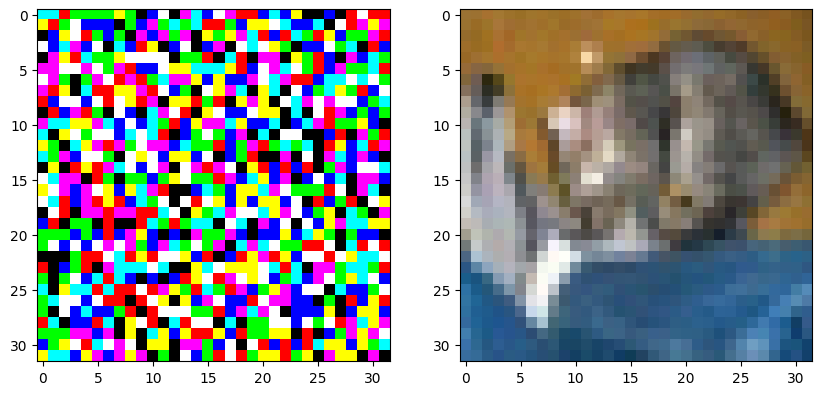

In [46]:
# visualize random pattern, and what it looks like applied to an image
perturbations = create_random_adversarial_pattern(x_train[0].shape)
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1, 2, 1)
plt.imshow(perturbations * 0.5 + 0.5)
fig.add_subplot(1, 2, 2)
plt.imshow(tf.clip_by_value(x_test[0] + 0.01 * perturbations, 0, 1))

In [47]:
eps = 0.01
x_random_adv_test = np.empty(x_test.shape)
for i in range(0, len(x_test)):
    x_random_adv_test[i] = x_test[i] + eps * create_random_adversarial_pattern(x_test[0].shape)
    x_random_adv_test[i] = tf.clip_by_value(x_random_adv_test[i], 0, 1)
    

loss, accuracy = model.evaluate(x_random_adv_test, y_test_one_hot, verbose=1)
print(loss, accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8312 - loss: 0.5099
0.5051049590110779 0.8310999870300293


Adding noise after the fgsm perturbation seems to improve performance slightly

In [53]:
# what if we add random noise after the fgsm perturbation?
eps = 0.05
random_x_test = np.empty(x_test.shape)
for i in range(0, 100):
    random_x_test[i] = x_adv_test[i] + eps * create_random_adversarial_pattern(x_test[0].shape)

loss, accuracy = model.evaluate(random_x_test[:100], y_test_one_hot[:100], verbose=1)
print(loss, accuracy)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3567 - loss: 2.8359 
2.8631722927093506 0.3499999940395355


Can we use this to come up with a more robust model, for free?

In [54]:
# adds n different instances of random noise to image, outputs the most voted class of the perturbed images
def one_model_ensemble_predict(image, eps, n):
    perturbed_images = np.empty((n, *image.shape))
    for i in range(n):
        perturbed_images[i] = image + eps * create_random_adversarial_pattern(image.shape)
    predictions = model(perturbed_images)
    pred_indices = np.argmax(predictions, axis=1)
    return stats.mode(pred_indices, keepdims=False)[0]

In [55]:
# evaluate our one_model_ensemble performance
num_correct = 0
total = 100
for i in range(0, 100):
    y_pred = one_model_ensemble_predict(x_adv_test[i], eps=0.05, n=1)
    if y_pred == y_test[i]: num_correct += 1

num_correct / total

0.35

Lol not really